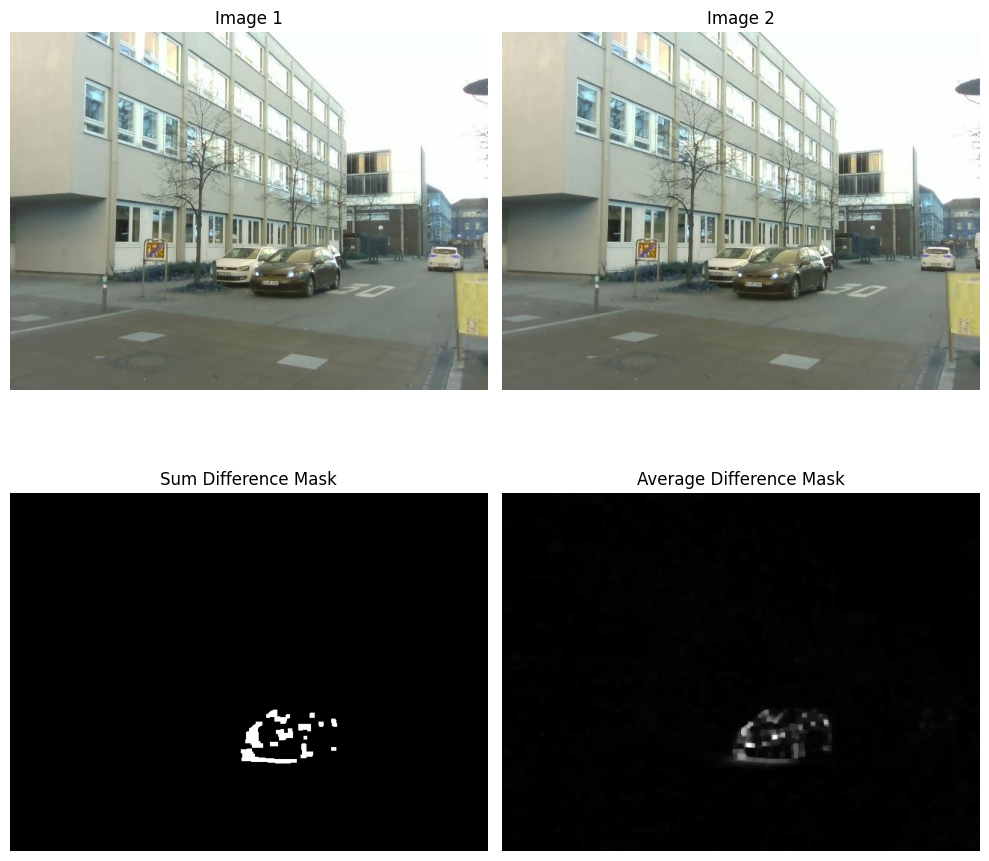

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_image_diff(img1: np.ndarray, img2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute difference masks between two images using sum and average methods
    
    Args:
        img1: First input image as numpy array
        img2: Second input image as numpy array
        
    Returns:
        tuple containing:
            - Difference mask using sum of channel differences
            - Difference mask using average of channel differences
    """
    # Ensure images are same size
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    # Convert to float32 for calculations
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    
    # Calculate absolute difference for each channel
    diff = np.abs(img1 - img2)
    
    # Method 1: Sum differences across channels
    sum_diff = np.sum(diff, axis=2)
    # Normalize to 0-255 range
    sum_diff = (sum_diff * 255.0 / sum_diff.max()).astype(np.uint8)
    
    # Method 2: Average differences across channels
    avg_diff = np.mean(diff, axis=2)
    # Normalize to 0-255 range
    avg_diff = (avg_diff * 255.0 / avg_diff.max()).astype(np.uint8)
    
    return sum_diff, avg_diff

# Example usage:
img1 = cv2.imread('tmp/front_frame_0494.jpg')
img2 = cv2.imread('tmp/front_frame_0495.jpg')

if img1 is not None and img2 is not None:
    # Convert BGR to RGB for matplotlib
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Get initial difference masks
    sum_mask, avg_mask = compute_image_diff(img1, img2)
    
    # Define kernel size for morphological operations
    kernel = np.ones((5,5), np.uint8)
    
    # Apply morphological operations to remove noise
    # Opening (erosion followed by dilation) removes small bright spots
    # Closing (dilation followed by erosion) removes small dark spots
    sum_mask = cv2.morphologyEx(sum_mask, cv2.MORPH_OPEN, kernel)
    sum_mask = cv2.morphologyEx(sum_mask, cv2.MORPH_CLOSE, kernel)
    
    avg_mask = cv2.morphologyEx(avg_mask, cv2.MORPH_OPEN, kernel)
    avg_mask = cv2.morphologyEx(avg_mask, cv2.MORPH_CLOSE, kernel)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Plot original images and difference masks
    axes[0,0].imshow(img1_rgb)
    axes[0,0].set_title('Image 1')
    axes[0,0].axis('off')
    
    axes[0,1].imshow(img2_rgb)
    axes[0,1].set_title('Image 2')
    axes[0,1].axis('off')
    
    axes[1,0].imshow(np.where(sum_mask > 20, 255, 0), cmap='gray')
    axes[1,0].set_title('Sum Difference Mask')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(avg_mask, cmap='gray')
    axes[1,1].set_title('Average Difference Mask')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Error loading images")



In [32]:
import rosbag
import roslib, rospy
from cv_bridge import CvBridge
import cv2


TOPIC_FRONT = '/head_front_camera/color/image_raw/compressed'
TOPIC_BACK = '/cam_new_back/color/image_raw/compressed'

def CreateVideoBag(videopath, bagname):
    '''Creates a bag file with a video file'''
    bag = rosbag.Bag(bagname, 'w')
    cap = cv2.VideoCapture(videopath)
    cb = CvBridge()
    prop_fps = cap.get(cv2.CAP_PROP_FPS)
    if prop_fps != prop_fps or prop_fps <= 1e-2:
        print("Warning: can't get FPS. Assuming 30.")
        prop_fps = 30
    ret = True
    frame_id = 0
    while(ret):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        stamp = rospy.rostime.Time.from_sec(float(frame_id) / prop_fps)
        frame_id += 1
        image = cb.cv2_to_compressed_imgmsg(frame)
        image.header.stamp = stamp
        image.header.frame_id = "camera"
        bag.write(TOPIC_FRONT, image, stamp)
        bag.write(TOPIC_BACK, image, stamp)
    cap.release()
    bag.close()

CreateVideoBag('IMG_0986.MOV', 'bags/phone_test.bag')

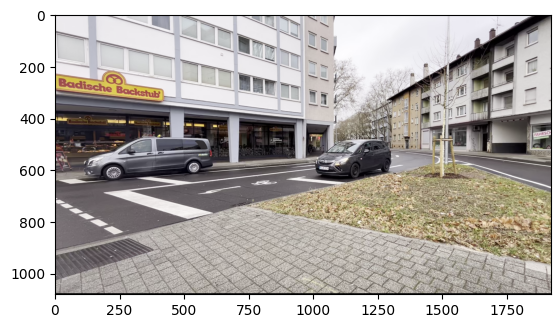

In [30]:
cap = cv2.VideoCapture('IMG_0986.MOV')
plt.imshow(cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB))

In [34]:
import openvino as ov
from pathlib import Path
from ultralytics import YOLO

# Initialize OpenVINO Core
core = ov.Core()

# Export YOLO model to OpenVINO format
model = YOLO('yolo11x.pt')
model.export(format='openvino', dynamic=True)

# Load and compile OpenVINO model
DET_MODEL_NAME = 'yolo11x'
det_model_path = Path(f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml") 
det_ov_model = core.read_model(det_model_path)

# Get available devices
devices = core.available_devices
print(f"Available devices: {devices}")

# Compile model for CPU/GPU
device = "GPU" if "GPU" in devices else "CPU"
det_compiled_model = core.compile_model(det_ov_model, device)


Ultralytics 8.3.47 🚀 Python-3.9.20 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 5955WX 16-Cores)
YOLO11x summary (fused): 464 layers, 56,919,424 parameters, 0 gradients, 194.9 GFLOPs

PyTorch: starting from 'yolo11x.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (109.3 MB)

OpenVINO: starting export with openvino 2024.5.0-17288-7975fa5da0c-refs/pull/3856/head...
OpenVINO: export success ✅ 5.6s, saved as 'yolo11x_openvino_model/' (217.7 MB)

Export complete (7.1s)
Results saved to /mnt/md0/kit_data
Predict:         yolo predict task=detect model=yolo11x_openvino_model imgsz=640  
Validate:        yolo val task=detect model=yolo11x_openvino_model imgsz=640 data=/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app
Available devices: ['CPU']


In [35]:
core.available_devices

['CPU']